### HOUSE SALE PRICING PREDICTION

**PREPROCESSING & EDA**

- Importing Libraries & Data
- Dealing with Duplicates and Nan
- Looking at correlations
- Data Normalization (Plots & Tests)


**MODELING**

- Baseline Models with 10-Folds CV
- Best Model (RandomGridSearch)
- Prediction
- Submission

In [1]:
# IMPORTING LIBRARIES & MAIN PATH

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# IMPORTING DATA

house_data = pd.read_csv('./Data/Historical.csv')
test = pd.read_csv('./Data/Target.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RowId                    1138 non-null   int64  
 1   Front_Length             932 non-null    float64
 2   Area                     1138 non-null   int64  
 3   Street_Type              1138 non-null   object 
 4   Area_Shape               1138 non-null   object 
 5   Flatness                 1138 non-null   object 
 6   Prop_Config              1138 non-null   object 
 7   Neighborhood             1138 non-null   object 
 8   Building_Type            1138 non-null   object 
 9   Building_Style           1138 non-null   object 
 10  Quality_Rating           1138 non-null   int64  
 11  Condition_Rating         1138 non-null   int64  
 12  Year_Constructed         1138 non-null   int64  
 13  Year_Remodelled          1138 non-null   int64  
 14  RoofStyle               

In [3]:
data_w.head()

RowId  Front_Length   Area Street_Type          Area_Shape Flatness  \
0      1          65.0   8450    Pavement             Regular      Lvl   
1      2          80.0   9600    Pavement             Regular      Lvl   
2      3          68.0  11250    Pavement  Slightly Irregular      Lvl   
3      4          60.0   9550    Pavement  Slightly Irregular      Lvl   
4      5          84.0  14260    Pavement  Slightly Irregular      Lvl   

  Prop_Config Neighborhood Building_Type Building_Style  ...  \
0      Inside      Andheri          1Fam         2Story  ...   
1         FR2       Bandra          1Fam         1Story  ...   
2      Inside      Andheri          1Fam         2Story  ...   
3      Corner     Borivali          1Fam         2Story  ...   
4         FR2      Dahisar          1Fam         2Story  ...   

   Garage_Car_Capacity  GarageArea  Garage_Quality  Wood_Deck_Area  \
0                    2         548              TA               0   
1                    2         460              TA             298   
2                    2         608              TA               0   
3                    3         642              TA               0   
4                    3         836              TA             192   

  Open_Porch_Area Enclosed_Porch_Area Three_Season_Porch_Area  \
0              61                   0                       0   
1               0                   0                       0   
2              42                   0                       0   
3              35                 272                       0   
4              84                   0                       0   

  Screen_Porch_Area Pool_Area  SalePrice  
0                 0         0     208500  
1                 0         0     181500  
2                 0         0     223500  
3                 0         0     140000  
4                 0         0     250000  

[5 rows x 53 columns]

### EDA & VISUALIZATION

Before working with any kind of data it is important to understand them. A crucial step to this aim is the ***Exploratory data analysis (EDA)***: a combination of visualizations and statistical analysis (uni, bi, and multivariate) that helps us to better understand the data we are working with and to gain insight into their relationships. So, let's explore our target variable and how the other features influence it.

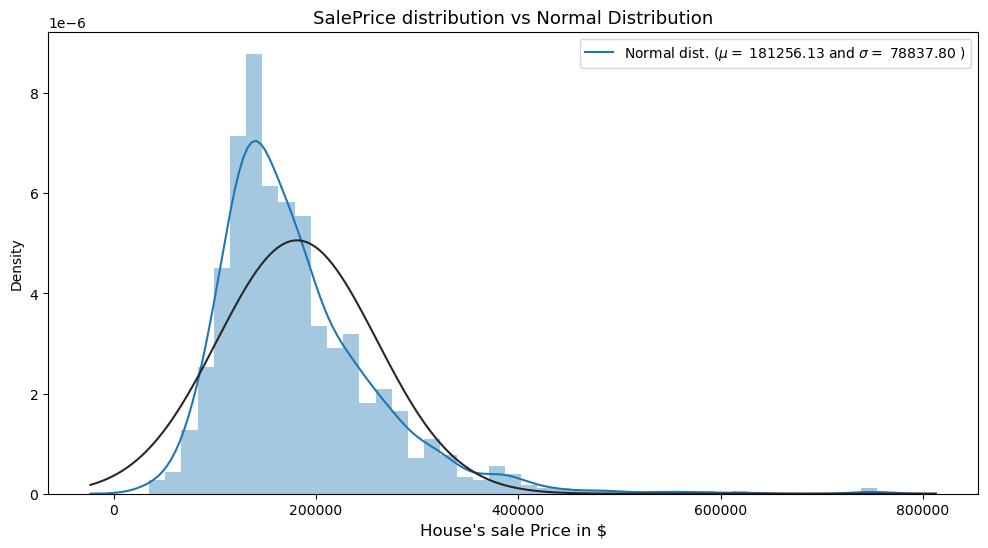

In [46]:
# Getting the main parameters of the Normal Ditribution ()
(mu, sigma) = norm.fit(data_w['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(data_w['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis. Looking at the plot, we can clearly see how the distribution does not seem to be normal, but highly right-skewed. The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). Despite that, let's leave it like that for now, we'll deal with that later in the notebook. 

In [47]:
# Skew and kurt
from scipy import stats

shap_t,shap_p = stats.shapiro(data_w['SalePrice'])

print("Skewness: %f" % abs(data_w['SalePrice']).skew())
print("Kurtosis: %f" % abs(data_w['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.903433
Kurtosis: 7.143028
Shapiro_Test: 0.872149
Shapiro_Test: 0.000000


The correlation matrix is the best way to see all the numerical correlation between features. Let's see which are the feature that correlate most with our target variable.

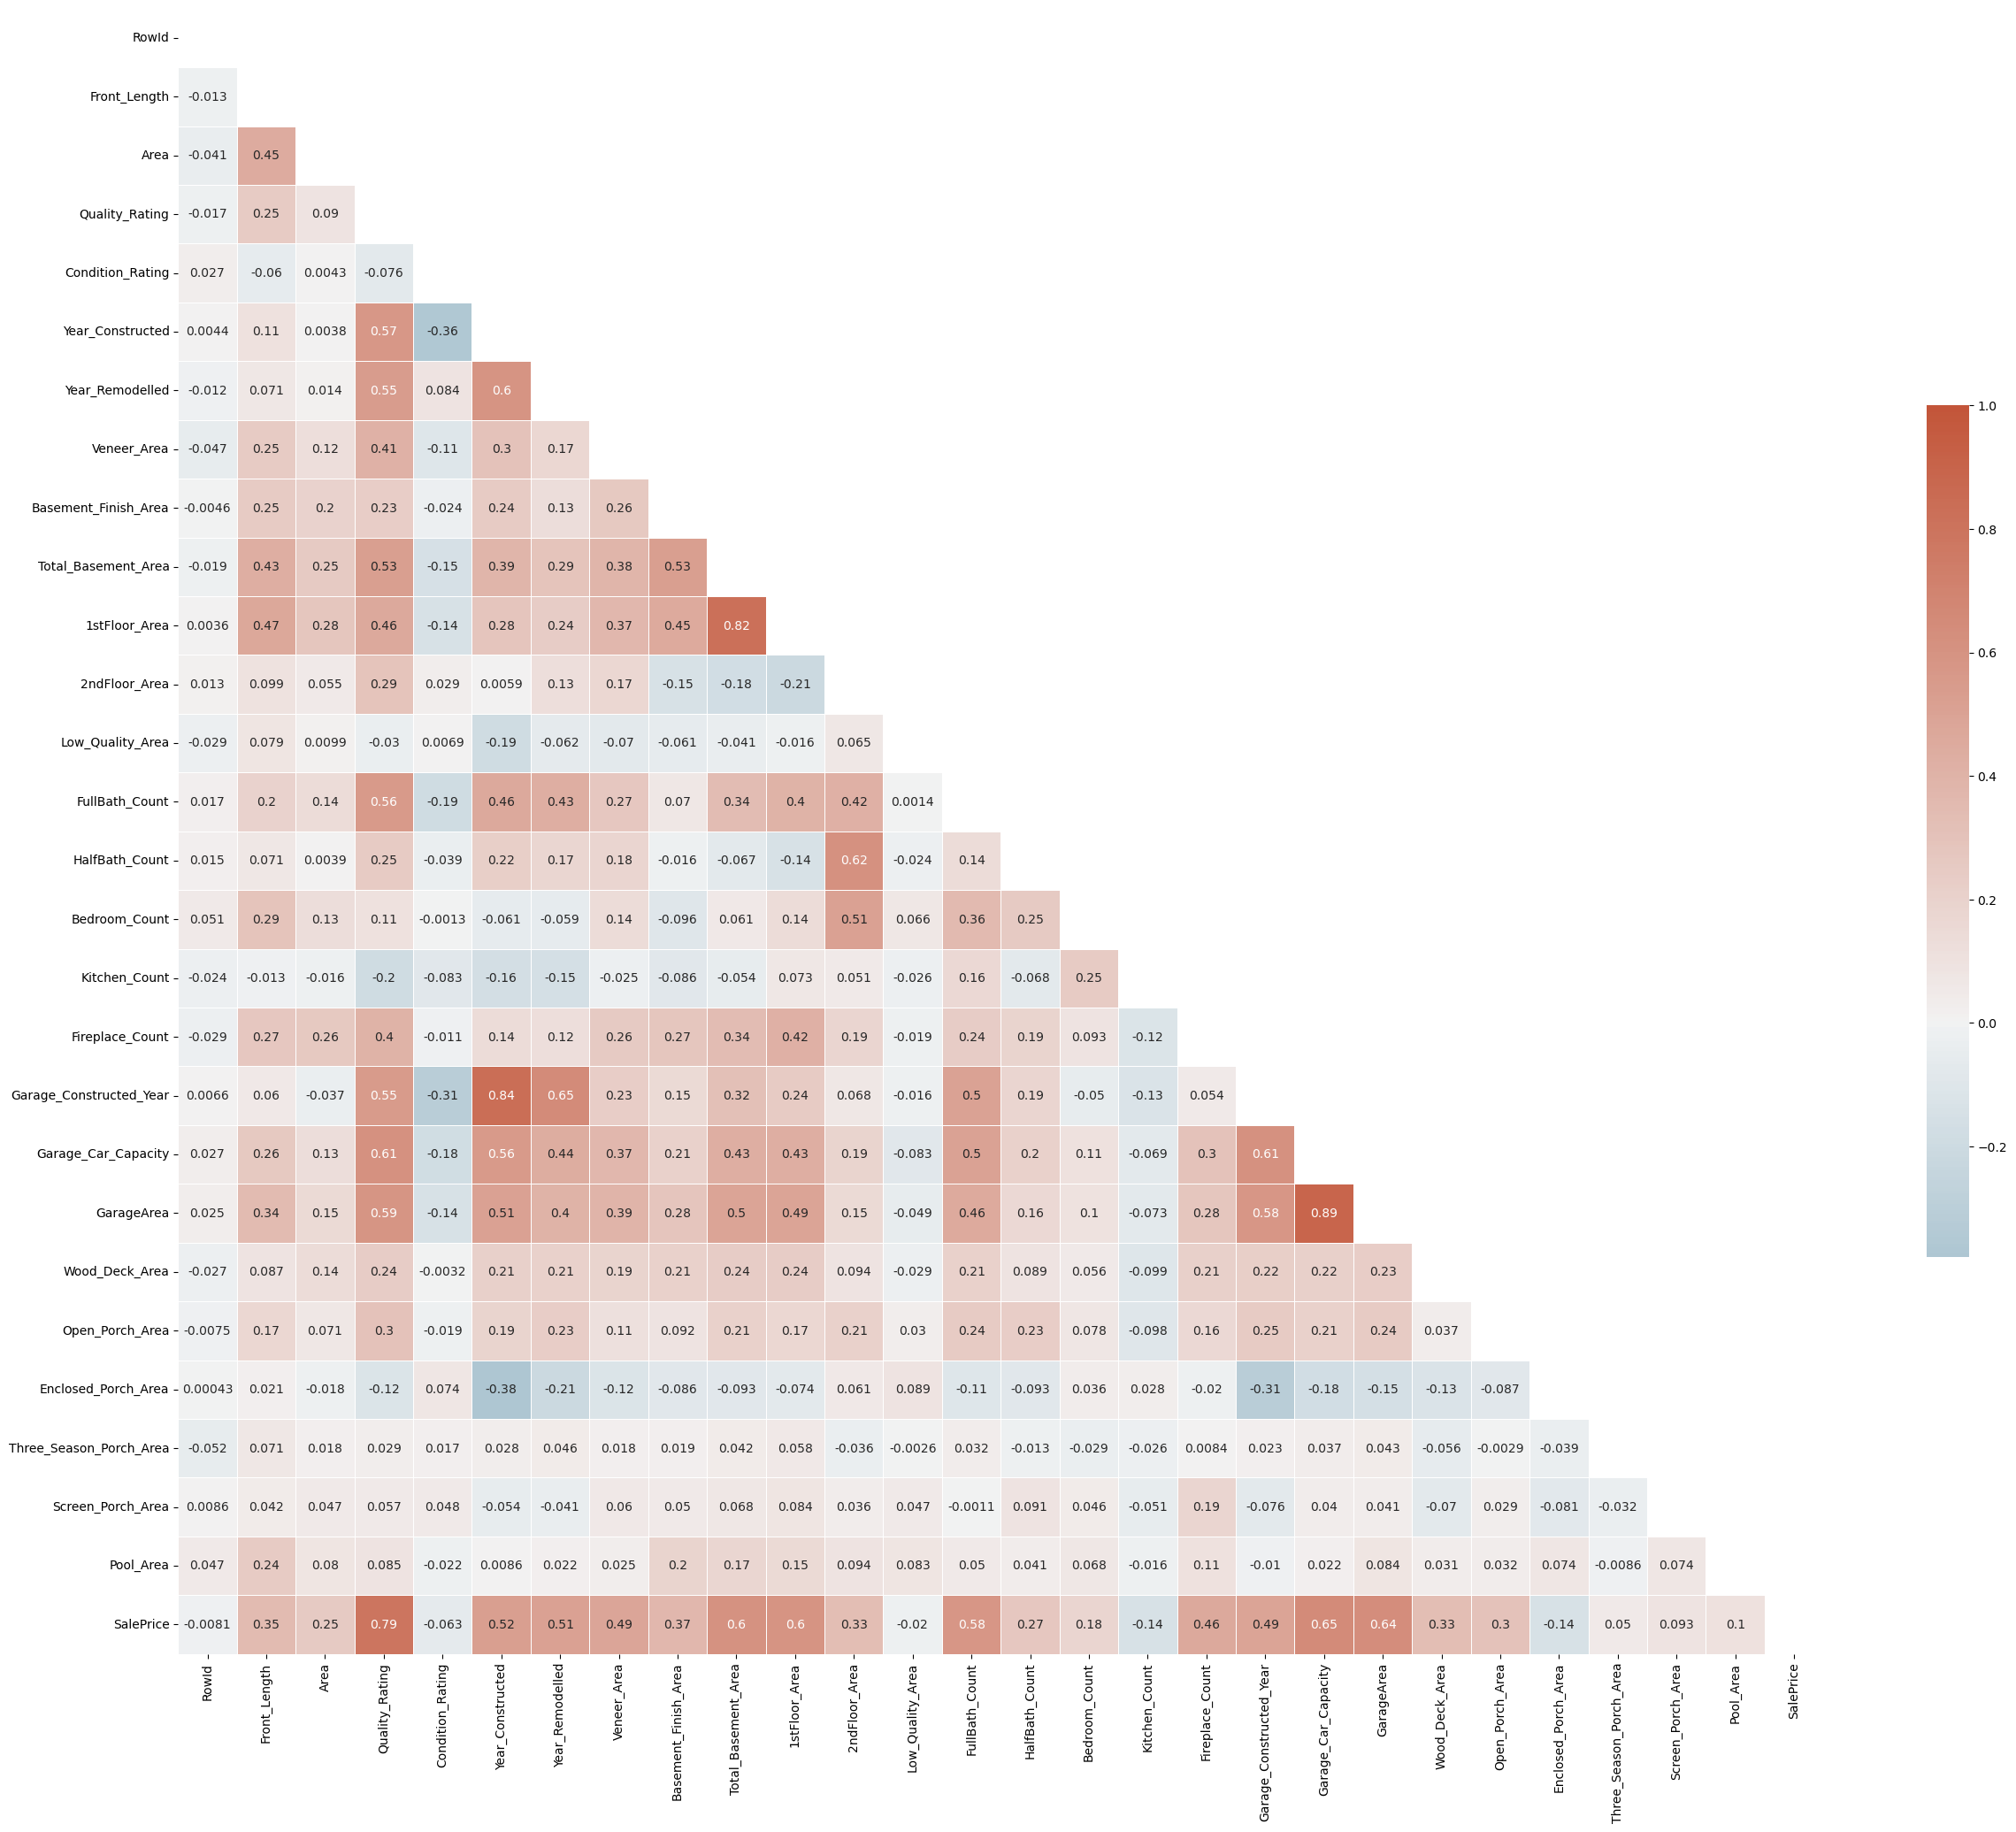

In [48]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = data_w.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Now that we know which features correlates most with our target variable we can investigate them more in depth.

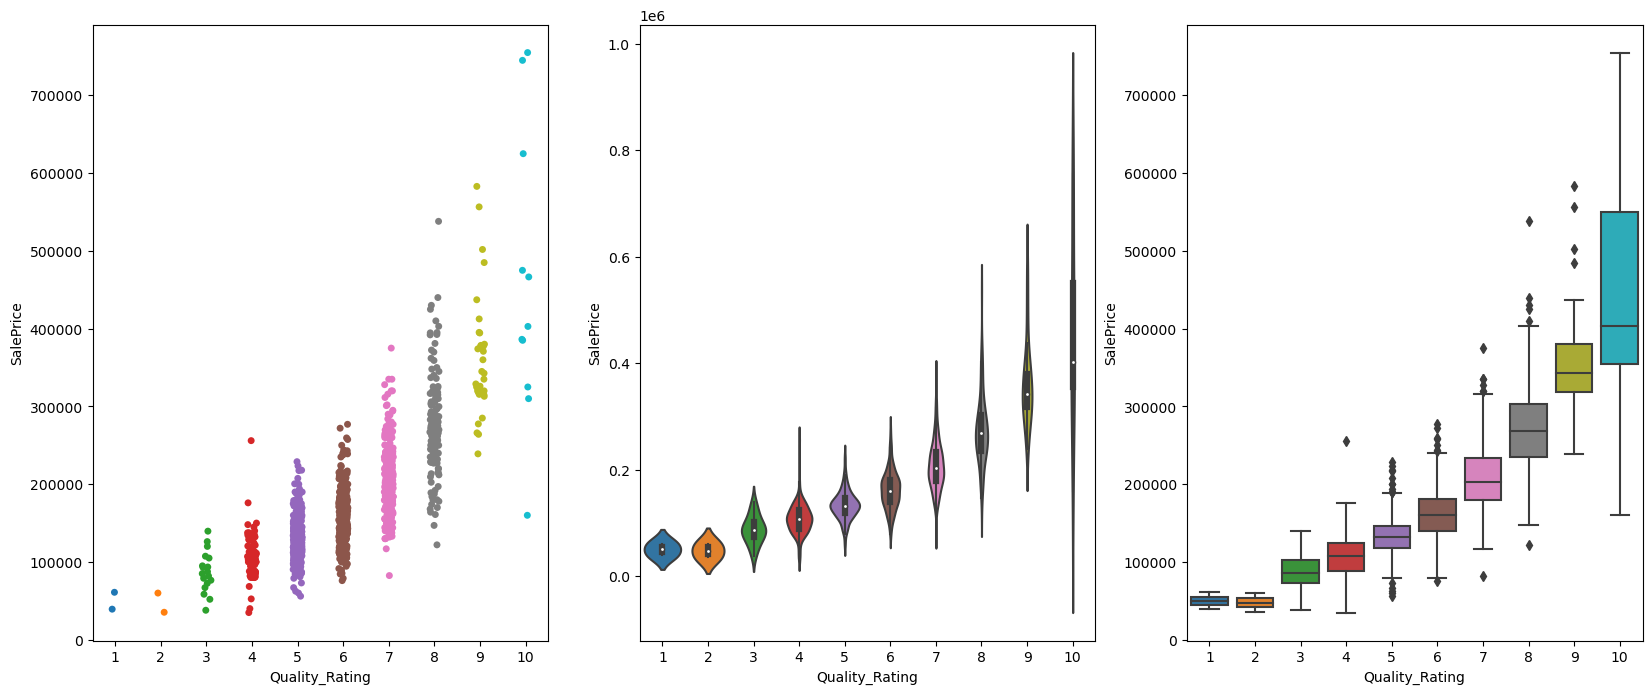

In [49]:
# Quality_Rating - SalePrice [Pearson = 0.8]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'Quality_Rating', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'Quality_Rating', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'Quality_Rating', y='SalePrice', ax = ax[2])
plt.show()

In [50]:
data_w['TotRmsAbvGrd'] = data_w.apply( lambda x : x['Bedroom_Count'] + x['Kitchen_Count'], axis=1)

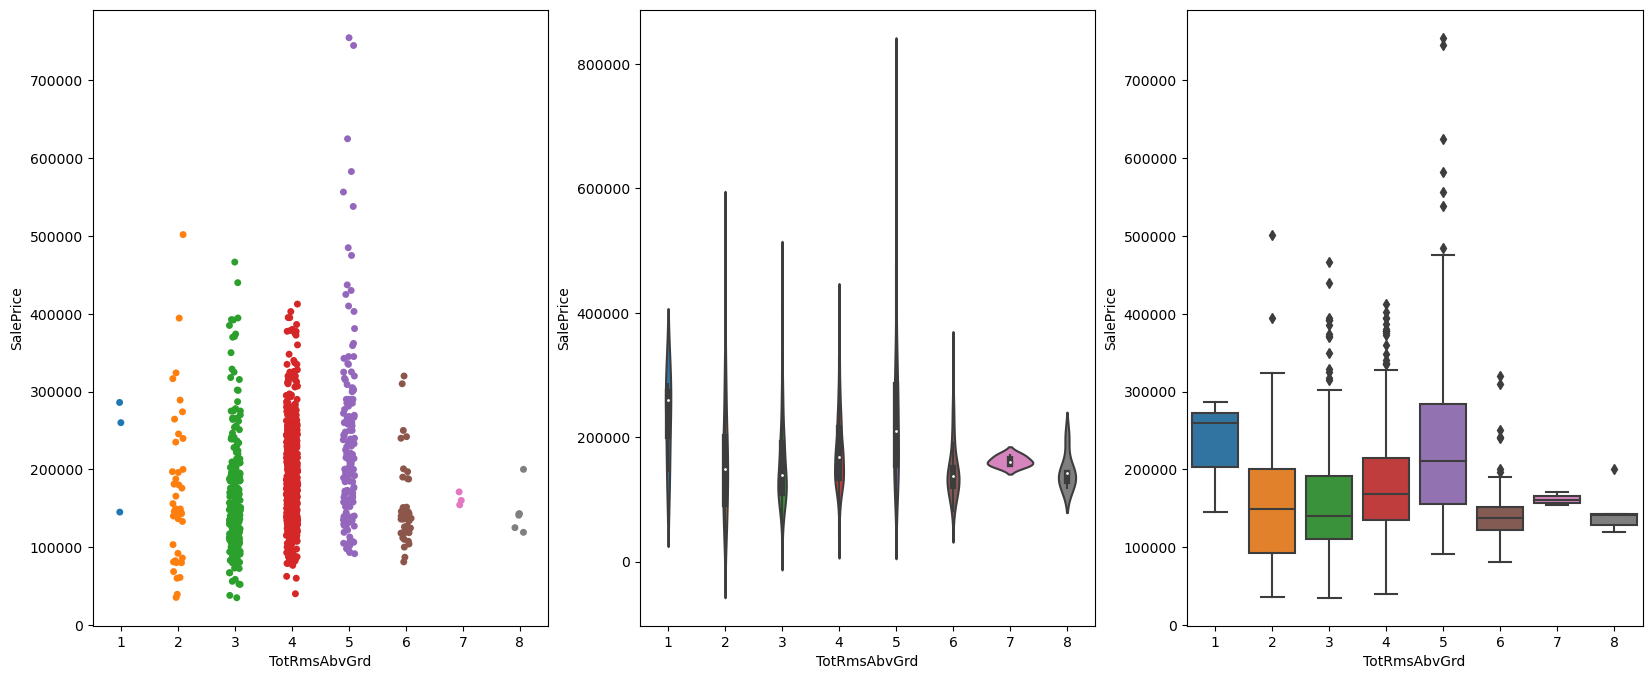

In [51]:
# TotRmsAbvGrd - SalePrice [Pearson = 0.50]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[2])
plt.show()

In [52]:
# GrLivArea vs SalePrice [corr = 0.71]

Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

KeyError: 'GrLivArea'

<Figure size 1200x600 with 0 Axes>

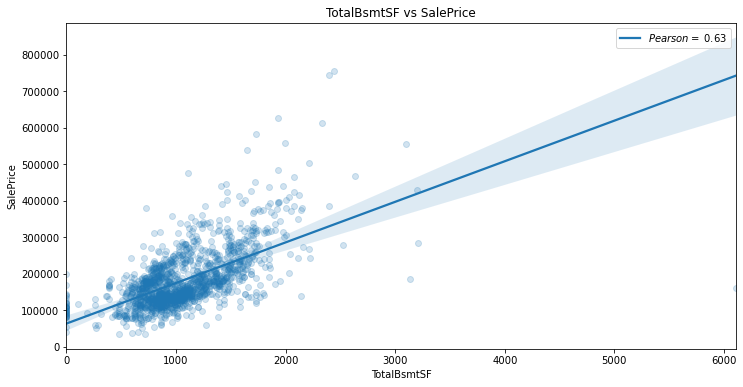

In [ ]:
Pearson_TBSF = 0.63
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')
plt.show()

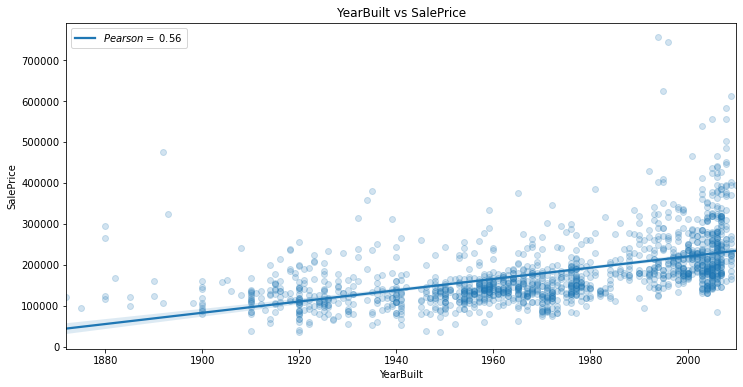

In [ ]:
# YearBuilt vs SalePrice

Pearson_YrBlt = 0.56
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'YearBuilt', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('YearBuilt vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_YrBlt)], loc = 'best')
plt.show()

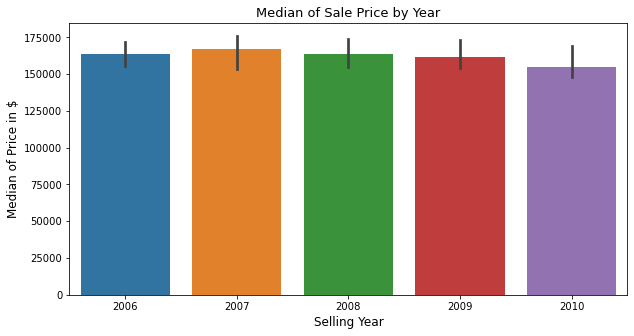

In [ ]:
# Median of Sale Price by Year

plt.figure(figsize = (10,5))
sns.barplot(x='YrSold', y="SalePrice", data = data_w, estimator = np.median)
plt.title('Median of Sale Price by Year', fontsize = 13)
plt.xlabel('Selling Year', fontsize = 12)
plt.ylabel('Median of Price in $', fontsize = 12)
plt.show()

###  DATA PREPROCESSING

Now that we have some insights about data, we need to preprocess them for the modeling part. The main steps are:

- Looking at potential NaN
- Dealing with categorical features (e.g. Dummy coding)
- Normalization

N.B:

Usually, in a real-world project, the test data are not available until the end. For this reason, test data should contain the same type of data of the training set to preprocess them in the same way. Here, the test set is available. It contains some observations not present in the training dataset and,the use of dummy coding could raise several issues (I spent a lot of time figuring out why I was not able to make predictions on the test set). The easiest way to solve this problem (that is not applicable if test data are not available) is to concatenate Train and Test sets, preprocess, and divide them again.


In [4]:
print(data_w.shape)
print(test.shape)

(1138, 53)
(322, 52)


In [5]:
# Separating Target and Features

target = data_w['SalePrice']
test_id = test['Row Id']
test = test.drop(['Row Id'],axis = 1)
data_w2 = data_w.drop(['SalePrice'], axis = 1)


# Concatenating train & test set

train_test = pd.concat([data_w2,test], axis=0, sort=False)

In [6]:
# Looking at NaN % within the data

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

NaN_sum                     feat    Perc(%) Usability
Electrical                     1               Electrical   0.068493      Keep
Veneer_Type                    8              Veneer_Type   0.547945      Keep
Veneer_Area                    8              Veneer_Area   0.547945      Keep
Basement_Quality              37         Basement_Quality   2.534247      Keep
Basement_Finish               37          Basement_Finish   2.534247      Keep
GarageType                    81               GarageType   5.547945      Keep
Garage_Constructed_Year       81  Garage_Constructed_Year   5.547945      Keep
GarageFinish                  81             GarageFinish   5.547945      Keep
Garage_Quality                81           Garage_Quality   5.547945      Keep
Front_Length                 259             Front_Length  17.739726      Keep
RowId                        322                    RowId  22.054795   Discard
Fireplace_Quality            690        Fireplace_Quality  47.260274   Discard

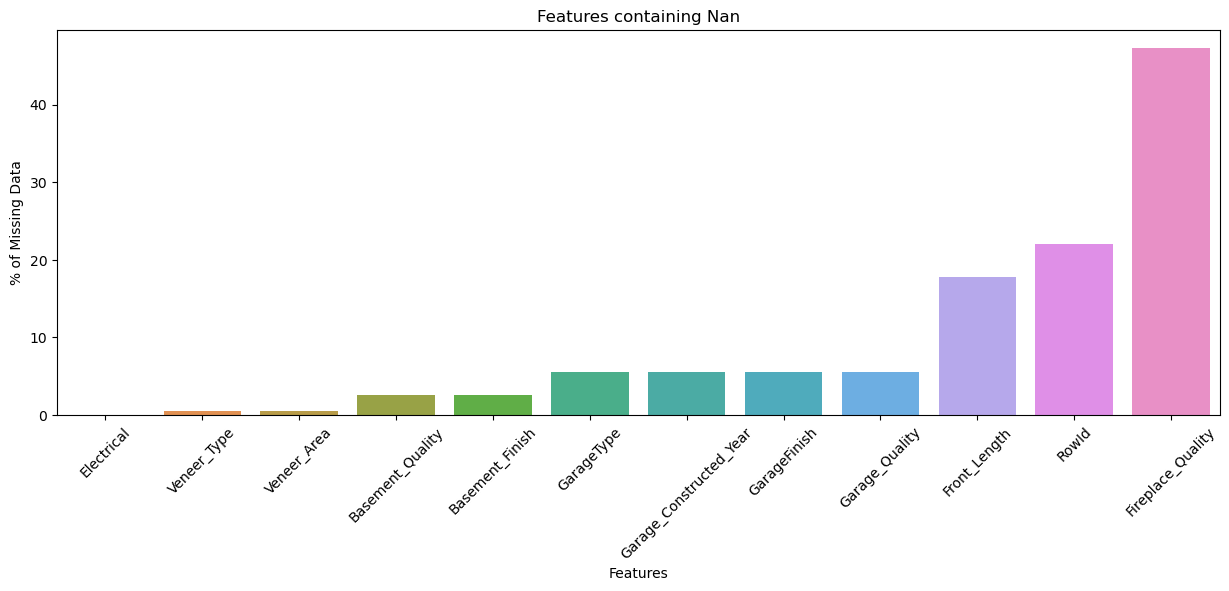

In [7]:
# Plotting Nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Are we sure that all these nans are real missing values? Looking at the given description file, we can see how the majority of these nans reflect the absence of something, and for this reason, they are not nans. We can impute them (for numerical features) or substitute them with data in the file:

In [8]:
na_cols = nan.index
train_test[na_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 321
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Electrical               1459 non-null   object 
 1   Veneer_Type              1452 non-null   object 
 2   Veneer_Area              1452 non-null   float64
 3   Basement_Quality         1423 non-null   object 
 4   Basement_Finish          1423 non-null   object 
 5   GarageType               1379 non-null   object 
 6   Garage_Constructed_Year  1379 non-null   float64
 7   GarageFinish             1379 non-null   object 
 8   Garage_Quality           1379 non-null   object 
 9   Front_Length             1201 non-null   float64
 10  RowId                    1138 non-null   float64
 11  Fireplace_Quality        770 non-null    object 
dtypes: float64(4), object(8)
memory usage: 148.3+ KB


In [9]:
train_test['Garage_Quality'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: Garage_Quality, dtype: int64

In [10]:
# Filling Categorical NaN

train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['Veneer_Type'] = train_test['Veneer_Type'].fillna("None")
train_test['Veneer_Area'] = train_test['Veneer_Area'].fillna(0)
train_test['Basement_Quality'] = train_test['Basement_Quality'].fillna(train_test['Basement_Quality'].mode()[0])
train_test['Basement_Finish'] = train_test['Basement_Finish'].fillna(train_test['Basement_Finish'].mode()[0])
train_test["GarageType"] = train_test["GarageType"].fillna("None")
train_test["Garage_Constructed_Year"] = train_test["Garage_Constructed_Year"].fillna(0)
train_test['GarageFinish'] = train_test['GarageFinish'].fillna("None")
train_test['Garage_Quality'] = train_test['Garage_Quality'].fillna("None")
train_test['Front_Length'] = train_test['Front_Length'].fillna(0)

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

0    1.0
0    NaN
Name: RowId, dtype: float64
0    NaN
0    NaN
Name: Fireplace_Quality, dtype: object


In [11]:
# Removing the useless variables

useless = ['RowId','Fireplace_Quality'] 
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnRegressor (we can also use different Imputers)

def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

### FEATURE ENGINEERING

Let's create some new features combining the ones that we already have. These could help us to increase the performance of the model!

In [12]:
train_test["SqFtPerRoom"] = (train_test["1stFloor_Area"] + train_test["2ndFloor_Area"]) / ( train_test["Bedroom_Count"] +
                                train_test["Kitchen_Count"] +
                                train_test["HalfBath_Count"] +
                                train_test["FullBath_Count"])

train_test['Total_Home_Quality'] = train_test['Quality_Rating'] + train_test['Condition_Rating']

train_test['Total_Bathrooms'] = (train_test['FullBath_Count'] + (0.5 * train_test['HalfBath_Count']))

# train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string

# train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
# train_test['YearrSold'] = train_test['YrSold'].apply(str)
# train_test['MoSold'] = train_test['MoSold'].apply(str)

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

#train_test['Id'] = train_test['Id'].apply(str)
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

Now let's try to tranform our target distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see the transformation effect.  

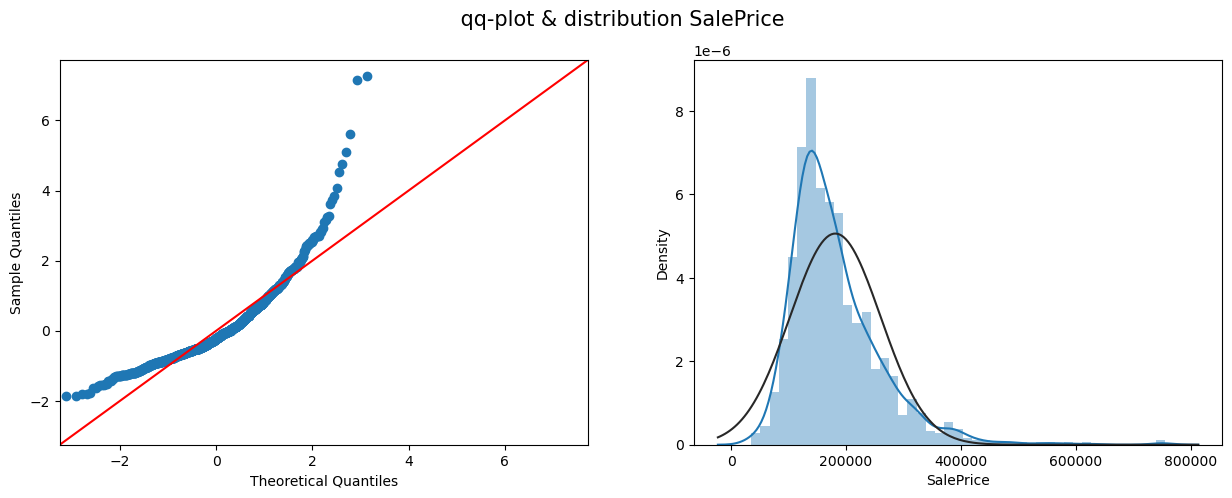

In [13]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

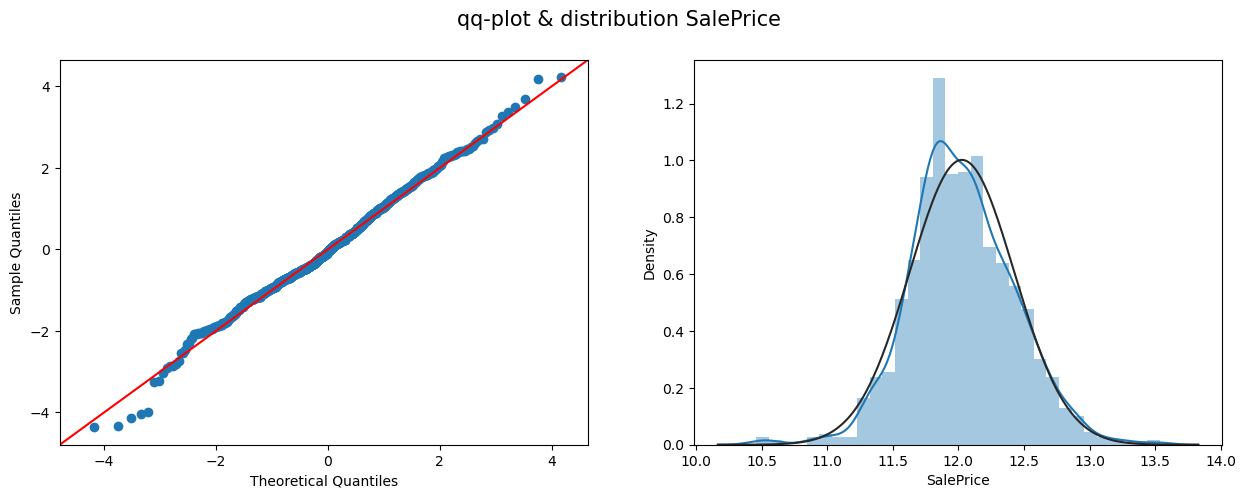

In [14]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

### MODELING

In [15]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [16]:
# Train-Test separation

train = train_test_dummy[0:1138]
test = train_test_dummy[1138:]
test['Id'] = test_id

# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [17]:
train_test_dummy.shape

(1460, 182)

In [18]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [19]:
train.tail()

Front_Length      Area  Quality_Rating  Condition_Rating  \
1133          62.0  8.976894               6          1.791759   
1134          85.0  9.486152               6          1.945910   
1135          66.0  9.109746               7          2.302585   
1136          68.0  9.181735               5          1.945910   
1137          75.0  9.204121               5          1.945910   

      Year_Constructed  Year_Remodelled  Veneer_Area  Basement_Finish_Area  \
1133              1999             2000     0.000000              0.000000   
1134              1978             1988     4.787492              6.673298   
1135              1941             2006     0.000000              5.620401   
1136              1950             1996     0.000000              3.912023   
1137              1965             1965     0.000000              6.722630   

      Total_Basement_Area  1stFloor_Area  2ndFloor_Area  Low_Quality_Area  \
1133             6.860664       6.860664       6.543912               0.0   
1134             7.341484       7.637234       0.000000               0.0   
1135             7.050123       7.080868       7.050123               0.0   
1136             6.983790       6.983790       0.000000               0.0   
1137             7.136483       7.136483       0.000000               0.0   

      FullBath_Count  HalfBath_Count  Bedroom_Count  Kitchen_Count  \
1133               2        0.693147              3       0.693147   
1134               2        0.000000              3       0.693147   
1135               2        0.000000              4       0.693147   
1136               1        0.000000              2       0.693147   
1137               1        0.693147              3       0.693147   

      Fireplace_Count  Garage_Constructed_Year  Garage_Car_Capacity  \
1133         0.693147                   1999.0                    2   
1134         1.098612                   1978.0                    2   
1135         1.098612                   1941.0                    1   
1136         0.000000                   1950.0                    1   
1137         0.000000                   1965.0                    1   

      GarageArea  Wood_Deck_Area  Open_Porch_Area  Enclosed_Porch_Area  \
1133         460        0.000000         3.713572             0.000000   
1134         500        5.857933         0.000000             0.000000   
1135         252        0.000000         4.110874             0.000000   
1136         240        5.905362         0.000000             4.727388   
1137         276        6.602588         4.234107             0.000000   

      Three_Season_Porch_Area  Screen_Porch_Area  Pool_Area  SqFtPerRoom  \
1133                      0.0                0.0        0.0     5.465042   
1134                      0.0                0.0        0.0     5.847883   
1135                      0.0                0.0        0.0     5.814983   
1136                      0.0                0.0        0.0     5.600272   
1137                      0.0                0.0        0.0     5.348694   

      Total_Home_Quality  Total_Bathrooms  Street_Type_Gravel  \
1133                  11              2.5                 0.0   
1134                  12              2.0                 0.0   
1135                  16              2.0                 0.0   
1136                  11              1.0                 0.0   
1137                  11              1.5                 0.0   

      Street_Type_Pavement  Area_Shape_Irregular  \
1133                     1                   0.0   
1134                     1                   0.0   
1135                     1                   0.0   
1136                     1                   0.0   
1137                     1                   0.0   

      Area_Shape_Moderately Irregular  Area_Shape_Regular  \
1133                              0.0                   1   
1134                              0.0                   1   
1135                              0.0   

In [37]:
train.to_csv("train_for_modelling.csv",index=False)

In [1]:
test.tail()

NameError: name 'test' is not defined

In [21]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_rmse(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgbr = xgb.XGBRegressor()
score_xgb = cv_rmse(xgbr)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = CatBoostRegressor(),
                              use_features_in_secondary = True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

Learning rate set to 0.041097
0:	learn: 0.3929891	total: 60.3ms	remaining: 1m
1:	learn: 0.3834820	total: 61.6ms	remaining: 30.7s
2:	learn: 0.3733168	total: 62.8ms	remaining: 20.9s
3:	learn: 0.3640352	total: 64.1ms	remaining: 15.9s
4:	learn: 0.3546017	total: 65.2ms	remaining: 13s
5:	learn: 0.3460831	total: 66.6ms	remaining: 11s
6:	learn: 0.3378719	total: 68.1ms	remaining: 9.66s
7:	learn: 0.3298055	total: 69.6ms	remaining: 8.63s
8:	learn: 0.3229380	total: 70.8ms	remaining: 7.8s
9:	learn: 0.3155770	total: 72ms	remaining: 7.13s
10:	learn: 0.3090670	total: 73.4ms	remaining: 6.6s
11:	learn: 0.3017075	total: 74.8ms	remaining: 6.16s
12:	learn: 0.2953165	total: 76.2ms	remaining: 5.79s
13:	learn: 0.2889893	total: 77.5ms	remaining: 5.46s
14:	learn: 0.2829718	total: 78.8ms	remaining: 5.18s
15:	learn: 0.2773816	total: 80.2ms	remaining: 4.93s
16:	learn: 0.2719370	total: 81.2ms	remaining: 4.69s
17:	learn: 0.2663117	total: 82.5ms	remaining: 4.5s
18:	learn: 0.2614364	total: 83.8ms	remaining: 4.33s
19:	

In [22]:
final_cv_score

Regressors  RMSE_mean  RMSE_std
0          Linear_Reg.   0.136968  0.035938
1  Bayesian_Ridge_Reg.   0.128551  0.036011
2            LGBM_Reg.   0.134940  0.025665
3                  SVR   0.277958  0.031235
4        Dec_Tree_Reg.   0.212680  0.020653
5   Random_Forest_Reg.   0.143395  0.029118
6             XGB_Reg.   0.141509  0.025276
7      Grad_Boost_Reg.   0.132748  0.026767
8       Cat_Boost_Reg.   0.125903  0.028599
9         Stacked_Reg.   0.124804  0.028322

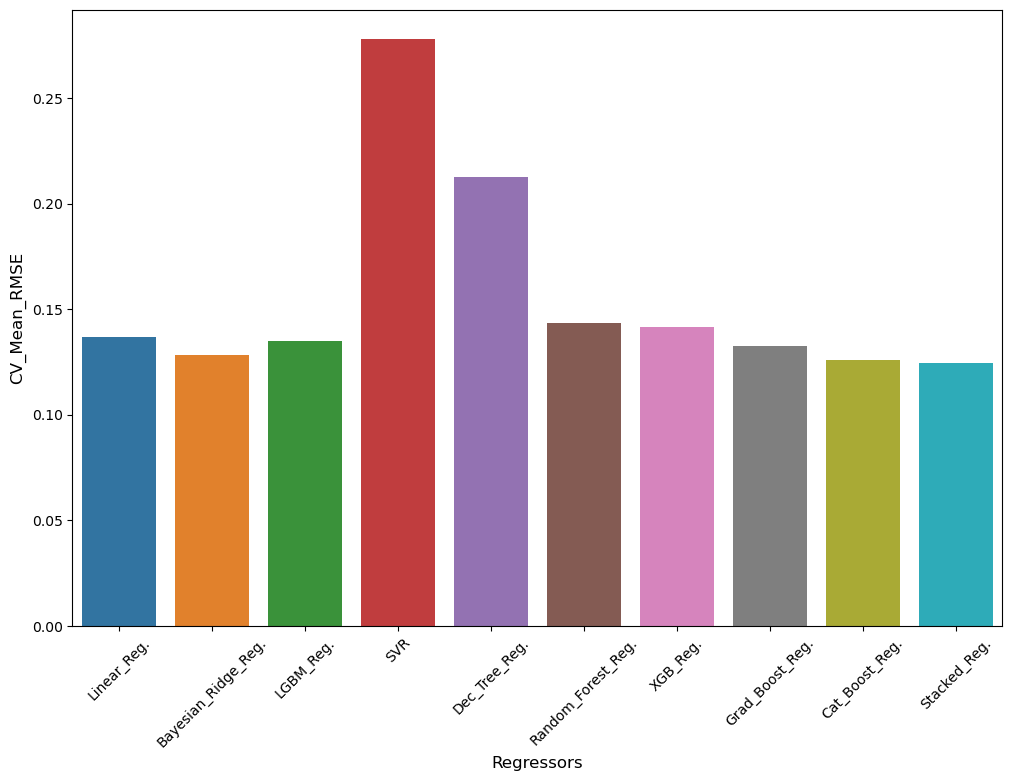

In [23]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Regressors'],final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [24]:
# Train-Test split the data

X_train,X_val,y_train,y_val = train_test_split(train,target_log,test_size = 0.1,random_state=42)

# Cat Boost Regressor

cat = CatBoostRegressor()
cat_model = cat.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = 0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
cat_pred = cat_model.predict(X_val)
cat_score = rmse(y_val, cat_pred)
cat_score

0.0949739196533459

Now let's take a look at the top 20 most important variables for our model. This could give us further insight into the functioning of the algorithm and how and which data it uses most to arrive at the final prediction.

In [26]:
# Features' importance of our model

feat_imp = cat_model.get_feature_importance(prettified=True)
feat_imp.head(10)

Feature Id  Importances
0        Quality_Rating    19.665550
1           SqFtPerRoom     7.315234
2   Total_Basement_Area     7.098029
3       Total_Bathrooms     6.468096
4                  Area     4.630097
5    Total_Home_Quality     4.150430
6      Year_Constructed     3.799436
7  Basement_Finish_Area     3.521298
8         1stFloor_Area     3.435555
9   Garage_Car_Capacity     2.834988

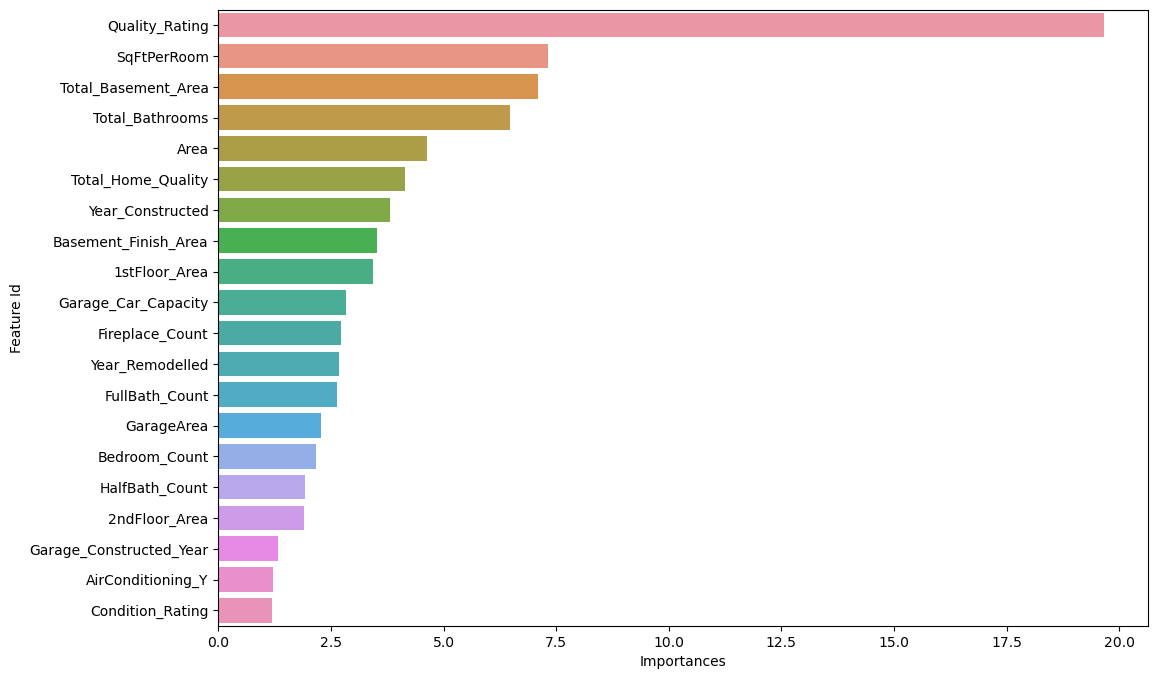

In [27]:
# Plotting top 20 features' importance

plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.show()

In [79]:
# Feature importance Interactive Plot 

# train_pool = Pool(X_train)
# val_pool = Pool(X_val)

# explainer = shap.TreeExplainer(cat_model) # insert your model
# shap_values = explainer.shap_values(train_pool) # insert your train Pool object

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

# The plot represents just a slice of the Training data (200 observations)

In [81]:
# shap.summary_plot(shap_values, X_train)

The above diagram represents each observation (x-axis) for the feature presented (y-axis). The x location of each dot on the x-axis reflects the impact of that feature on the model's predictions, while the color of the dot represents the value of that feature for that exact observation. Dots that pile up on the line show density. Here we can see how features such as 'BsmtFinType1_GLQ' or 'BsmtQual_Ex', differently from 'GrLivArea' and 'OverallQual', do not contribute significantly in producing the final predictions.



 N.B: Catboost comes with a great method: ***get_feature_importance***. This method can be used to find important interactions among features. This is a huge advantage because it can give us insights about possible new features to create that can improve the performance.  

In [28]:
# Features' Interactions

train_data = Pool(X_train)

interaction = cat_model.get_feature_importance(train_data, type="Interaction")
column_names = X_train.columns.values 
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

feature1                 feature2  importance
0         Quality_Rating              SqFtPerRoom    0.802439
1         Quality_Rating               GarageArea    0.604253
2                   Area              SqFtPerRoom    0.592509
3   Basement_Finish_Area              SqFtPerRoom    0.583421
4                   Area           Quality_Rating    0.557846
5         Quality_Rating            1stFloor_Area    0.554692
6             GarageArea          Open_Porch_Area    0.547372
7    Total_Basement_Area            Bedroom_Count    0.535688
8         Quality_Rating          Total_Bathrooms    0.517201
9         Quality_Rating          Open_Porch_Area    0.512314
10                  Area  Garage_Constructed_Year    0.504005
11   Enclosed_Porch_Area              SqFtPerRoom    0.491138
12        Quality_Rating     Basement_Finish_Area    0.487491
13        Quality_Rating      Total_Basement_Area    0.467452
14         1stFloor_Area               GarageArea    0.466668
15   Total_Basement_Area              SqFtPerRoom    0.446511
16      Year_Constructed              SqFtPerRoom    0.426400
17       Year_Remodelled              SqFtPerRoom    0.426003
18        Quality_Rating  Garage_Constructed_Year    0.419128
19         Bedroom_Count              SqFtPerRoom    0.399399

Which are the deafult parameters used by CaboostRegressor? This is our real baseline, now we need to optimize the hyperparameters trying to tune the model to obtain a better performance.

In [29]:
# Catboost default paramters

cat_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.05111100152134895,
 'score_function': 'Cosine',
 'task_type':

### Hyperparameter Optimization

In [30]:
# Preforming a Random Grid Search to find the best combination of parameters

grid = {'iterations': [1000,6000],
        'learning_rate': [0.05, 0.005, 0.0005],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 9]}

final_model = CatBoostRegressor()
randomized_search_result = final_model.randomized_search(grid,
                                                   X = X_train,
                                                   y= y_train,
                                                   verbose = False,
                                                   plot=True)
                                                   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 12.0363291	test: 12.0137654	best: 12.0137654 (0)	total: 2.63ms	remaining: 2.63s
1:	learn: 12.0303649	test: 12.0078377	best: 12.0078377 (1)	total: 4.02ms	remaining: 2.01s
2:	learn: 12.0244043	test: 12.0018989	best: 12.0018989 (2)	total: 6.1ms	remaining: 2.03s
3:	learn: 12.0184556	test: 11.9959529	best: 11.9959529 (3)	total: 7.28ms	remaining: 1.81s
4:	learn: 12.0125119	test: 11.9900116	best: 11.9900116 (4)	total: 9.84ms	remaining: 1.96s
5:	learn: 12.0065469	test: 11.9840895	best: 11.9840895 (5)	total: 12.7ms	remaining: 2.1s
6:	learn: 12.0005940	test: 11.9781161	best: 11.9781161 (6)	total: 15.3ms	remaining: 2.17s
7:	learn: 11.9946554	test: 11.9721795	best: 11.9721795 (7)	total: 17.1ms	remaining: 2.12s
8:	learn: 11.9887157	test: 11.9662564	best: 11.9662564 (8)	total: 18ms	remaining: 1.98s
9:	learn: 11.9828111	test: 11.9603409	best: 11.9603409 (9)	total: 19.3ms	remaining: 1.91s
10:	learn: 11.9768594	test: 11.9544027	best: 11.9544027 (10)	total: 20.6ms	remaining: 1.85s
11:	learn: 1

In [31]:
randomized_search_result['params']

{'depth': 4, 'l2_leaf_reg': 1, 'iterations': 6000, 'learning_rate': 0.005}

In [32]:
# Final Cat-Boost Regressor

params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}
         
cat_f = CatBoostRegressor(**params)
cat_model_f = cat_f.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = False)

catf_pred = cat_model_f.predict(X_val)
catf_score = rmse(y_val, catf_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
catf_score

0.09703432605095774

### SUBMISSION

In [34]:
# Test CSV Submission

test_pred = cat_f.predict(test)
submission = pd.DataFrame(test_id.values, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

Id      SalePrice
0   1  127332.631437
1   2  112295.098293
2   3  130991.090054
3   4  135339.137248
4   5  129063.756462

In [35]:
# Saving the results in a csv file

submission.to_csv("./Data/prediction.csv", index = False, header = True)